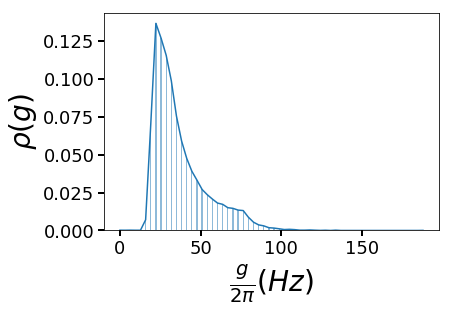

In [1]:
from scipy import constants as sp
import os
import numpy as np
from matplotlib import pyplot as plt
from qsd.data_processing import readcomsol,postproc,setparams

# Read data from downloads
file_dbx = os.getcwd() + '/downloads/exports/Bx_fullData.csv'
file_dby = os.getcwd() + '/downloads/exports/By_fullData.csv'

rdx = readcomsol.ReadComsol(file_dbx)
rdy = readcomsol.ReadComsol(file_dby)

# Read csv file, and get x,y annd dbx/dby data for each
# blocked point in space
bx_x,bx_y,bx_z = rdx.read_full_data()
by_x,by_y,by_z = rdy.read_full_data()

dbx = np.asarray(bx_z).astype(np.float)
dby = np.asarray(by_z).astype(np.float)

# Define geometry of the superconductor
setp = setparams.SetParams()
params = setp.set_params("cpw_parameters.txt")

w = params["w"]
t = params["t"]
l = params["l"]
pen = params["pen"]
omega = params["omega"]
Z = params["Z"]

# Postprocess data
post = postproc.PostProc(w,t,l,pen,omega,Z)

# Single spin coupling for each point on mesh grid
g = post.coupling(dbx,dby,theta=0)

hist, edges = post.spin_density(bx_x,bx_y,g,bins=60) # density

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(edges,hist,'-')
ax1.bar(edges,height=hist,alpha=0.5)
plt.xlabel('$\\frac{g}{2 \pi} (Hz)$',fontsize=28)
plt.ylabel('$\\rho(g)$',fontsize=28)
ax1.tick_params(direction='out', length=6, width=2, colors='k',labelsize=18)
plt.show()

In [2]:
def spinmap(xin,yin,spin_depth):
    xs = xin[(yin >= -spin_depth) & (yin <= 0.0)]
    ys = yin[(yin >= -spin_depth) & (yin <= 0.0)]
    return xs,ys

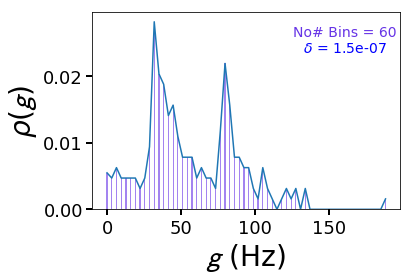

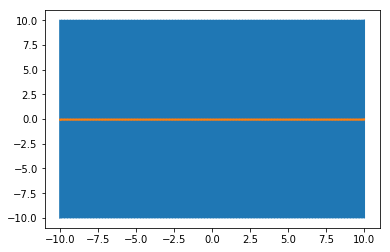

In [2]:
# Define spin map
x = np.asarray(bx_x).astype(float)
y = np.asarray(bx_y).astype(float)
spin_depth = 150e-03 # um

xs,ys = post.spinmap(x,y,spin_depth)

# dbxs = [dbx[np.where(y==y[i])] for i in range(len(ys))]
# dbys = [dbx[np.where(y==y[i])] for i in range(len(ys))]

dbxs = dbx[(y >= -spin_depth) & (y <= 0.0)]
dbys = dby[(y >= -spin_depth) & (y <= 0.0)]

# Single spin coupling for each point on mesh grid
gs = post.coupling(dbxs,dbys,theta=0)

bin_num = 60

hist_s, edges_s = np.histogram(gs, density=True, bins=bin_num)
edges_s = edges_s[0:len(hist_s)]

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(edges_s,hist_s,'-')
ax1.bar(edges_s,height=hist_s,color=(.4,.2,.9),alpha=0.6)
plt.xlabel('$\\mathcal{g}$ (Hz)',fontsize=28)
plt.ylabel('$\\rho(\\mathcal{g})$',fontsize=28)
plt.text(0.82, 0.9, 'No# Bins = %s'%bin_num, color=(.4,.2,.9), 
         horizontalalignment='center',verticalalignment='center', 
         fontsize=14, transform=ax1.transAxes)
plt.text(0.82, 0.82, '$\delta$ = %s'%str(spin_depth*1e-06), color=(0,0,1), 
         horizontalalignment='center',verticalalignment='center', 
         fontsize=14, transform=ax1.transAxes)
ax1.tick_params(direction='out', length=6, width=2, colors='k',labelsize=18)
plt.tight_layout()
plt.show()
fig.savefig(os.getcwd() + '/figs/g_density_delta.eps')

plt.plot(x,y)
plt.plot(xs,ys)
plt.show()

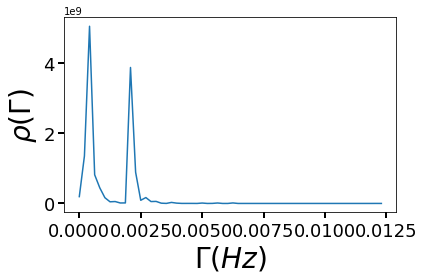

In [3]:
# Calculate Purcell enhancement at each grid point
Q = 10000 # Q factor - for now typed in, but will be found from CST calcs ultimately
purcell = post.purcell_rate(gs,Q)

bin_num = 60

pdens_s, pedges_s = np.histogram(purcell, density=True, bins=bin_num)
pedges_s = pedges_s[0:len(pdens_s)]

# Weight by contribution to signal
g_weight = np.zeros(len(pedges_s))
for i in range (0,len(pedges_s)-1):
    g_weight[i] = sum(gs[np.where(np.logical_and(purcell>=pedges_s[i], purcell<=pedges_s[i+1]))])

rho_weighted = pdens_s * g_weight**2

fig = plt.figure()
plt.plot(pedges_s,rho_weighted,'-')
plt.xlabel('$\\Gamma (Hz)$',fontsize=28)
plt.ylabel('$\\rho(\\Gamma)$',fontsize=28)
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=18)
plt.tight_layout()
plt.show()
fig.savefig(os.getcwd() + '/figs/purcell_density.eps', dpi=fig.dpi)

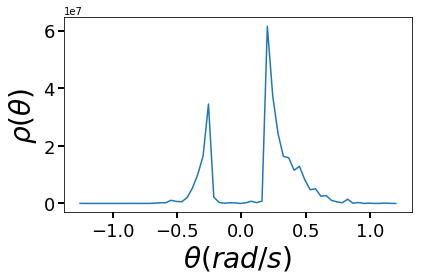

In [24]:
# Calculate total B1 field
theta = 0
B1 = post.B1(dbxs, dbys, theta)

# Calculate Larmor frequency
gamma = 4.32e07 # Bismuth gyromagnetic ratio (rad/T*s)
omega_larmor = post.larmor_omega(B1,gamma)
tau = 1
theta_larmor = post.larmor_theta(omega_larmor, tau)

bin_num = 60

lardens, laredge = np.histogram(theta_larmor, density=False, bins=bin_num)
laredge = laredge[0:len(lardens)]

# Weight theta with contribution to spin signal
g_weight = np.zeros(len(laredge))
for i in range (0,len(laredge)-1):
    g_weight[i] = sum(gs[np.where(np.logical_and(theta_larmor>=laredge[i], theta_larmor<=laredge[i+1]))])

rho_weighted = lardens * g_weight**2

fig = plt.figure()
plt.plot(laredge,rho_weighted,'-')
plt.xlabel('$\\theta (rad/s)$',fontsize=28)
plt.ylabel('$\\rho(\\theta)$',fontsize=28)
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=18)
plt.tight_layout()
plt.show()

In [5]:
dbxs = dbx[(y >= -spin_depth) & (y <= 0.0)]

In [6]:
dbx[(y==ys)]

/Users/garethjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], shape=(0, 40401), dtype=float64)

In [23]:
b = np.zeros(len(ys))
for i in range(len(ys)):
    b = dbx[np.where(y==y[i])]

In [8]:
dbxs = [dbx[np.where(y==y[i])] for i in range(len(ys))]

In [9]:
dbxs

[array([  1.78267293e-09,   1.80592736e-09,   1.82924493e-09,
          1.85263783e-09,   1.87603072e-09,   1.89945720e-09,
          1.92308049e-09,   1.94670378e-09,   1.97033192e-09,
          1.99410825e-09,   2.01788458e-09,   2.04166091e-09,
          2.06657025e-09,   2.09048786e-09,   2.11465574e-09,
          2.13882362e-09,   2.16311552e-09,   2.18747023e-09,
          2.21182494e-09,   2.23649162e-09,   2.26057678e-09,
          2.28515051e-09,   2.30972425e-09,   2.33430354e-09,
          2.35890341e-09,   2.38350329e-09,   2.40810316e-09,
          2.43270303e-09,   2.45754546e-09,   2.48147791e-09,
          2.50519746e-09,   2.53002471e-09,   2.55453428e-09,
          2.57829119e-09,   2.60247193e-09,   2.62665266e-09,
          2.65076439e-09,   2.67487393e-09,   2.69898347e-09,
          2.72229607e-09,   2.74555193e-09,   2.76859483e-09,
          2.79163772e-09,   2.81468061e-09,   2.83767037e-09,
          2.86039148e-09,   2.88311259e-09,   2.90583371e-09,
        

In [8]:
bx_x.count(bx_x[0])

201

In [12]:
xss=list(xs)
xss.count(xs[0])

2

In [15]:
if type(xs) != list:
    xs = list(xs)

True